# Coffee roasting in tensorflow
- Here we will use tensorflow to create, train, test a neural netowrk using the coffee roasting example.
- The training data is taken from the coursera course lab utilities.
- The neural network consists of a hidden layer(3 neurons) and an output layer(1 neuron).
- The network is trained to distinguish between a good roasted coffee bean and a bad roasted coffee bean (0/1).
- The individual neurons use the sigmoid activation function.
- At the time of this implementation the concept of backpropagation is a black box for me.
### During this implementation the following functions/concepts related to tensorflow were learnt:
1) Eager execution/ Graph based execution in TensorFLow:
    - The autograph library allows us to convert python code to tensorflow graph code which optimises tensor computations
    - tensorflow.function decorator fucntion is used to convert a python function to a polymorphic tensorflow graph function

2) Python logging module:
    - it has functions related to keeping track of a program and looking for errors
    - errors have been divided into different types based on which they are filtered out

3) TensorFlow verbose:
    - the compile function in tensorflow(used for training a NN) has an additional parameter 'verbose' which provides different options to monitor the training of the neural network with different epochs.

4) Tiling of data:
    - this is a data preproccesing practice in which we copy the same data again and again in the dataset itself to increase the size of the dataset and recduce the number of epochs required to train the neural netowrk
    - keep in mind that a neural network is trained one data input at a time.
    - np.tile(numpy_arr, (X_dimension, Y_dimension)) is used.
    - this function copys the array as many times as specified by the dimensions in the respective axes

5) The subtle difference between NumPy arrays and TensorFlow tensors:
    - In NumPy: Axis=1 means operation along the row, Axis=0 means operation along the column.
    - In TenFl: Axis=1 means operation along the column, Axis=0 means operation along the row.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import lab_coffee_utils as lcu
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [2]:
X,Y=lcu.load_coffee_data()
print(X.shape, Y.shape)

# X is the input array, while Y is the output array 
# X[0] is the temprature, X[1] is the duration

(200, 2) (200, 1)


#### Visualising the dataset

In [3]:
print(X[Y[:,0]==1, 0].shape)

(43,)


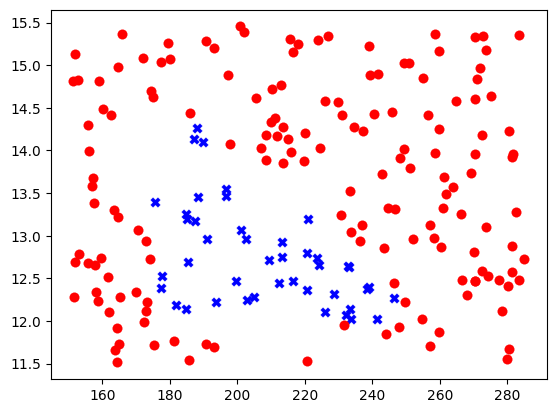

In [4]:
plt.scatter(X[Y[:,0]==1,0], X[Y[:,0]==1,1], marker='X', color='b', linewidths=.1, s=50)
plt.scatter(X[Y[:,0]==0,0], X[Y[:,0]==0,1], marker='o', color='r', linewidths=.1, s=50)
plt.show()

In [5]:
a = np.array([0, 1, 2])
b=np.tile(a, (2,3))
print(b)
print(X.shape)

[[0 1 2 0 1 2 0 1 2]
 [0 1 2 0 1 2 0 1 2]]
(200, 2)


### Normalising the data using Z-score normalisation
- We can do it in the usual way but tensorflow.keras provides a normalisation layer which normalises the dataset along the given axis.

In [6]:
norm=tf.keras.layers.Normalization(axis=1) # norm is the normalisation layer object
norm.adapt(X) # adapt function calculates the value of mean and variance of each column(axis is set to be 0)
Xn=norm(X)

In [7]:
norm.mean

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[218.66783 ,  13.430685]], dtype=float32)>

### Tiling the dataset
    - np.tile(numpy_arr, (X_dimension, Y_dimension)) is used.
this function copys the array as many times as specified by the dimensions in the respective axes

In [8]:
Xt=np.tile(Xn,(1000,1))
Yt=np.tile(Y, (1000,1))

### Creating the neural network model
    - for creating the neural network we use tf.keras sequential and dense functions
    - the dense function is use to create a single layer of neurons
    - the sequential function combines the layers in its arguments to form a single neural netowrk
- input layer with 2 neurons
- 1 hidden layer with 3 neurons
- output layer with 1 neuron


In [9]:
layer_1=Dense(units=3, activation= 'sigmoid')
layer_2=Dense(units=1, activation= 'sigmoid')
nrl_ntwrk=Sequential([tf.keras.Input(shape=(2,)), layer_1, layer_2]) 
#the keras.input parameter specifying the size of the inputs is optional, detected in the model.fit function aswell

In [10]:
nrl_ntwrk.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
layer_1.get_weights()
#observe that the weights have been initialised randomly while the bias has been initialised with 0

[array([[ 1.0634494 , -0.5437592 , -0.3759727 ],
        [-0.51438576, -0.296543  , -0.77712905]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [12]:
layer_2.get_weights()

[array([[-0.42779893],
        [-0.55634195],
        [ 0.65034497]], dtype=float32),
 array([0.], dtype=float32)]

## Training the Neural Network
    - nrl_ntwrk.compile() function will define the loss function to be used while training and the compile optimisation
    - nrl_ntwrk.fit() will use the above loss fucntion for gradient descent to train the network's weights and biases

### There are 3 steps to trianing a MLP(multi-level perceptron)/Neural network
Traditionally each training instance is fed to the neural network (like we did for perceptrons) but tensorflow divides the training set into batches of 32(by default).
1) Forward propgation: the batch is fed to the neural network and predictions are made.
2) backward propagation: contribution of each weight of the network in the final error is calculated from the o/p layer
3) Gradient descent: each weight is tweaked a little bit according to the errors calculated

In [13]:
nrl_ntwrk.compile(loss= tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),)
nrl_ntwrk.fit(Xt, Yt, verbose=1, epochs=10)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2549
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1310
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.1173
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0607
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0187
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0120
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0083
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0059
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0042
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0031


In [14]:
print("weights and biases after training: ")
print("layer_1: ")
print(layer_1.get_weights())
print("layer_2: ")
print(layer_2.get_weights())

weights and biases after training: 
layer_1: 
[array([[ -0.06858014, -10.543765  , -17.367565  ],
       [ -8.551151  ,  -0.14527944, -14.566558  ]], dtype=float32), array([-10.709634 , -11.598016 ,  -2.5484874], dtype=float32)]
layer_2: 
[array([[-42.36786 ],
       [-46.64774 ],
       [ 33.265167]], dtype=float32), array([-9.073089], dtype=float32)]


### Testing the trained model
- we'll use some examples to test our model
- the output of the final neuron will be classified as 1(good roast) if its output > .5, else 0(bad roast).

In [15]:
X_test = np.array([[200,13.9],[200,17]])
X_testn=norm(X_test) #normalising the test data
a1=layer_1(X_testn)
a2=layer_2(a1)
print(a2)

a3=nrl_ntwrk.predict(X_testn)
print(a3)

tf.Tensor(
[[9.7011459e-01]
 [1.1050575e-04]], shape=(2, 1), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[9.7011453e-01]
 [1.1050575e-04]]


### Visualising what the individual neurons in the hidden layer represent

In [16]:
w1=layer_1.get_weights()
w1

[array([[ -0.06858014, -10.543765  , -17.367565  ],
        [ -8.551151  ,  -0.14527944, -14.566558  ]], dtype=float32),
 array([-10.709634 , -11.598016 ,  -2.5484874], dtype=float32)]

In [25]:
Xp=np.arange(-1.5,1.5,.1, dtype=float)
Xp1=np.arange(-1.12,-1.07,.01, dtype=float)

Y0= -(Xp*w1[0][0][0])/w1[0][1][0]-(w1[1][0]/w1[0][1][0])
Y1= -(Xp1*w1[0][0][1])/w1[0][1][1]-(w1[1][1]/w1[0][1][1])
Y2= -(Xp*w1[0][0][2])/w1[0][1][2]-(w1[1][2]/w1[0][1][2])

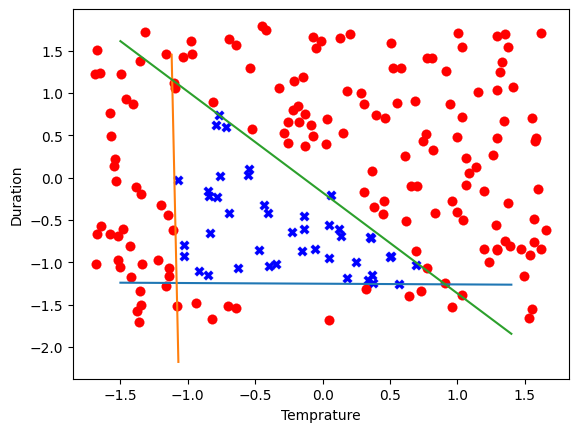

In [26]:
Xn2=np.array(Xn) # Xn is a tensor while Xn2 is a numpy array, this conversion is important
plt.scatter(Xn2[Y[:,0]==1,0], Xn2[Y[:,0]==1,1], marker='X', color='b', linewidths=.1, s=50)
plt.scatter(Xn2[Y[:,0]==0,0], Xn2[Y[:,0]==0,1], marker='o', color='r', linewidths=.1, s=50)
plt.plot(Xp,Y0)
plt.plot(Xp1,Y1)
plt.plot(Xp, Y2)
plt.xlabel('Temprature')
plt.ylabel('Duration')
plt.show()

Each desicion boundry corresponds to the output produced by a single neuron in layer-1